# IMPORTS

In this section we are importing and installing all necessary libraries:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/Shareddrives/INFO RETREIVAL/PROJECT/Part 2

/content/drive/Shareddrives/INFO RETREIVAL/PROJECT/Part 2


In [1]:
data_path = './data/'

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaumecamps/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.1 MB/s eta 0:00:00


In [8]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.8 MB/s eta 0:00:00


In [2]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import json
import re
import demoji
import time
from array import array


Build terms function from previous part: <br>

Note: We will use it to pre-process the input query

In [3]:
def build_terms(line):
    """
    Description:
    Preprocess the text (tweet) by removing stop words, punctuation (but keeping numbers), URLs,
    stemming, transforming to lowercase, and extracting hashtags. The hashtags are excluded
    from the preprocessed text.

    Input:
    line -- string (text) to be preprocessed

    Output:
    preprocessed_line -- a list of tokens corresponding to the input text after preprocessing
    hashtags -- a list of extracted hashtags
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Transform to lowercase
    line = line.lower()

    # HASHTAGS

    # Extract hashtags (keeping the # symbol)
    hashtags = re.findall(r'#\w+', line)
    # Remove punctuation but keep numbers
    hashtags = [re.sub(r'[^a-z0-9\s]', '', word) for word in hashtags]
    # Remove empty strings (in case stemming or other operations result in an empty hashtag)
    hashtags = [word for word in hashtags if word]

    # LINE

    # Remove emojis using demoji
    line = demoji.replace(line, " ")
    # Remove hashtags from the text --> remove all the word
    line = re.sub(r'#\w+', '', line)
    # Remove URLs
    line = re.sub(r'http\S+|www\S+|https\S+', '', line)
    # Remove punctuation but keep numbers (and hashtags are already removed)
    line = re.sub(r'[^a-z0-9\s]', '', line)
    # Tokenize the text to get a list of terms
    line = line.split()
    # Remove the word amp since & it is parsed as &amp and it is one of the most frequent words!
    line = [word for word in line if word != 'amp']
    # Remove stopwords
    line = [word for word in line if word not in stop_words]
    # Perform stemming
    line = [stemmer.stem(word) for word in line]

    # Return preprocessed text and hashtags
    return line, hashtags # return the preprocessed tweet content and hashtags

# Load the original and processed tweets json files

If data is not loaded from json files, then it will need to be imported farmer's protest tweets file, create the dictionaries and apply build terms function. With the already created dictionaries (in json files), data is loaded faster!

Note: Data from json files came from the dictionaries created in the first part of the project.

First let's load processed tweets dictionary:

In [4]:
with open(data_path + 'processed_tweets.json', 'r') as f:
    processed_tweets_dict = json.load(f)

In [5]:
print(f"We have {len(processed_tweets_dict)} processed tweets!")

We have 48429 processed tweets!


Print a sample:

In [6]:
processed_tweets_dict["doc_37"]

{'tweet': ['remain',
  'unit',
  'dont',
  'fall',
  'govt',
  'tactic',
  'tri',
  'hard',
  'creat',
  'divis',
  'within',
  'protest'],
 'hashtags': ['farmersprotest',
  'modiignoringfarmersdeaths',
  'farmersprotests',
  'modidontsellfarmers']}

Now let's load the original tweets dictionary:

In [7]:
with open(data_path + 'original_tweets.json', 'r') as f:
    original_tweets_dict = json.load(f)

Print same sample as before:

In [8]:
original_tweets_dict["doc_37"]

{'tweet': "Remain United 👇🏾👇🏾 Dont fall into govt's tactics they are trying hard to create a division within the protests #FarmersProtest #ModiIgnoringFarmersDeaths #FarmersProtests #ModiDontSellFarmers https://t.co/4eX8ckNLJT",
 'hashtags': ['#FarmersProtest',
  '#ModiIgnoringFarmersDeaths',
  '#FarmersProtests',
  '#ModiDontSellFarmers'],
 'date': '2021-02-24T08:57:35+00:00',
 'likes': 1,
 'retweets': 1,
 'url': 'https://twitter.com/B56Ricky/status/1364499704147374082'}

# INDEXING:

## Inverted Index

The following function creates an inverted index dictionary with the following structure:

![figure 2](https://drive.google.com/uc?export=view&id=1Le9fW_spJRNNWgTliHK6vAcMNAOJDJY8)
<caption><center> <u> <font color=''> Figure 1 </u><font color=''>  : Example of an inverted index with term's position information </center></caption>

That is, our final inverted index will contain, for each term, the document where it appears and its actual position/s (full inverted index).

In [9]:
def create_index(tweets):
    """
    Description:
    Creates a full inverted index based on the content of the dictionary

    Input:
    tweets -- dictionary with 'tweet' variable that contains the processed tweet content.

    Output:
    full inverted index with all the corpus processed terms, documents where they appear and its corresponding positions 
    """
    # init the dictionary
    index = defaultdict(list)

    for tweet_id, tweet_data in tweets.items():
        # get current tweet content (pre-processed)
        terms = tweet_data['tweet']
        # inverted index for current tweet
        current_tweet_index = defaultdict(lambda: [tweet_id, array('I')])  # defaultdict with list of positions
        #  Counts occurrences of each term in the tweet
        term_counts = defaultdict(int)

        # Build term frequency for this tweet and position lists
        for position, term in enumerate(terms):
            current_tweet_index[term][1].append(position)
            term_counts[term] += 1
        # Update index
        for term, (id, positions) in current_tweet_index.items():
            index[term].append([tweet_id, positions])
    return index

Inverted Index for tweet content:

In [10]:
index = create_index(processed_tweets_dict)

Here is the inverted intex for 'rain' word:

In [11]:
print(index['rain'])

[['doc_555', array('I', [4])], ['doc_4049', array('I', [0])], ['doc_5773', array('I', [10])], ['doc_6354', array('I', [5])], ['doc_10384', array('I', [9])], ['doc_11880', array('I', [4])], ['doc_12218', array('I', [1])], ['doc_14404', array('I', [16])], ['doc_16995', array('I', [15])], ['doc_18469', array('I', [13])], ['doc_24960', array('I', [9])], ['doc_25326', array('I', [3])], ['doc_25871', array('I', [6])], ['doc_26069', array('I', [2])], ['doc_32517', array('I', [7, 25])], ['doc_35314', array('I', [1])], ['doc_38132', array('I', [13])], ['doc_39395', array('I', [1])], ['doc_39695', array('I', [3])], ['doc_39879', array('I', [8])], ['doc_41832', array('I', [8])]]


## Test Queries

For the queries, we need to take a look at the previous part to select words properly.

As we have seen in the word cloud and term frequencies, words such as 'support', 'farmers', 'India', 'Human', 'Protest'... appear a lot in our corpus of tweets and we might get good results and a lot of documents to rank. 

In [12]:
# Based on the EDA from the previous part
query1 = "Are farmers being respected in India?"
query2 = "Is people supporting Farmers?"
query3 = "Fight of farmers in India"
query4 = "Impact of the Protests in India"
query5 = "Protest against Indian Government"

queries = [query1, query2, query3, query4, query5]

## Implement TF-IDF

In [13]:
def create_tfidf(tweets, num_documents):
    """
    Optimized inverted index creation with TF, DF, and IDF calculations.

    Input:
    tweets -- doctionary of preprocessed tweets
    num_documents -- total number of tweets in the corpus

    Output:
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    tf = defaultdict(list)  # term frequencies of terms in documents
    df = defaultdict(int)    # document frequencies of terms in the corpus
    idf = {}

    for tweet_id, tweet_data in tweets.items():
        terms = tweet_data['tweet']
        current_tweet_index = defaultdict(lambda: [tweet_id, array('I')])  # defaultdict with list of positions
        term_counts = defaultdict(int)  # Counts occurrences of each term in the tweet

        # Build term frequency for this tweet and position lists
        for position, term in enumerate(terms):
            current_tweet_index[term][1].append(position)
            term_counts[term] += 1

        # Calculate L2 norm for the tweet (once per document)
        norm = math.sqrt(sum(count ** 2 for count in term_counts.values()))

        # Update index, TF, and DF
        for term, (id, positions) in current_tweet_index.items():
            # Normalized term frequency
            tf_value = term_counts[term] / norm
            tf[term].append(np.round(tf_value, 4))

            # Increment DF count (only once per document per term)
            df[term] += 1
    # Compute IDF for each term
    for term, doc_count in df.items():
        idf[term] = np.round(np.log(num_documents / doc_count), 4)

    return tf, df, idf


In [14]:
start_time = time.time()
num_documents = len(processed_tweets_dict.keys())
tf, df, idf = create_tfidf(processed_tweets_dict, num_documents)
print("Total time to create the tf - idf - df dictionaries: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the tf - idf - df dictionaries: 1.65 seconds


Import a BERT model to compute the similarity between queries and hashtags:

In [15]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # multi-language model

/opt/anaconda3/envs/DEEP_LEARNING_COURSE/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [16]:
def get_embeddings(name_list):

    """
    Generates embeddings for a list of names using a pre-trained model.

    Input:
    name_list -- list of names (strings) for which embeddings are to be generated

    Output:
    embedding -- list of embeddings for each name in name_list
    """

    embedding = model.encode(name_list, convert_to_tensor=False)
    #print("Embedding shape: ", embedding.shape)
    return embedding

def bert_similarity(target_name, embedding, name_list, threshold=0.5):

    """
    Computes the cosine similarity between a target name and a list of names 
    based on their embeddings. Returns the highest similarity score if it 
    exceeds a threshold, otherwise returns 0.

    Input:
    target_name -- string, the name to compare against name_list
    embedding -- list of embeddings for each name in name_list (output of get_embeddings)
    name_list -- list of names (strings) corresponding to the embeddings
    threshold -- float, minimum similarity score to consider as a match (default 0.5)

    Output:
    best_match[1] -- float, the highest similarity score above the threshold
                     or 0 if no scores exceed the threshold
    """

    if pd.isna(target_name): return None

    target_embedding = model.encode(target_name, convert_to_tensor=False)

    # Compute cosine similarity scores
    cosine_scores = util.cos_sim(target_embedding, embedding)

    # Create a dictionary to store university names and their similarity scores
    similarity_scores = {}
    for i, name in enumerate(name_list):
        similarity_scores[name] = cosine_scores[0][i].item()

    # Sort the scores in descending order
    sorted_scores = dict(sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True))

    best_match = list(sorted_scores.items())[0]

    if best_match[1] > threshold:
        return best_match[1]
    else:
        return 0

Compute the best hashtags scores based on a given query:

In [17]:
def best_score (list_hashtags, query,threshold=0.5):

    """
    Finds the highest similarity score between a query and a list of hashtags
    using BERT embeddings, returning the score if it exceeds the threshold (0.5).

    Input:
    list_hashtags -- list of hashtags (strings) for which embeddings are to be generated
    query -- string, the query hashtag to compare against list_hashtags
    threshold -- decision point

    Output:
    float -- highest similarity score if it exceeds 0.5, otherwise 0
    """

    embeddings = get_embeddings(list_hashtags)
    return bert_similarity(query, embeddings, list_hashtags, threshold=threshold)

Now let's rank documents as follows:
- Given a query, we are creating a final weight with weighted sum of the cosine similarity between query and tweet content, and the BERT similarity between the query combinations and tweet hashtags. That is, if we have two same tweets but the first one has a hashtag relevant to the query and the other one no, then we are giving more score to the second tweet for the ranking.

Note: We are creating unions of two words of the query so that we're creating different hashtags from our input query. That is, if the input is "Support farmers of India", we are computing the similarity of hashtags vs "supportfarmer", "supportindia" & "farmerindia" (note that preprocessed query is "support farmer india").

In [18]:
def rank_documents(query, docs, index,processed_tweets, tf, idf, alpha=1, beta=3, flag=False):
    """
    Ranks documents based on their relevance (in descending order) to the query using TF-IDF scores.

    Input:
        query: The search query as a list of terms (preprocessed)
        docs: A list of document IDs to be ranked.
        index: The inverted index for tweets.
        processed_tweets: processed tweets dictionary
        tf: term frequency dictionary
        idf: The inverse document frequency dictionary.
        alpha: Weight for the TF-IDF score.
        beta: Weight for the similarity score between hashtags.
        flag: boolean which indicates whether to use or not the hashtag similarity score (additional to the tf-idf)

    Output:
        A list of document IDs sorted by their relevance to the query and their scores
    """
    doc_vectors = defaultdict(lambda: [0] * len(query))  # Initialize all scores to 0
    query_vector = [0] * len(query)

    query_terms_count = collections.Counter(query)

    query_norm = la.norm(list(query_terms_count.values()))


    for termIndex, term in enumerate(query):
        if term not in index:
        # as the term does not exist, return anything
            return []

        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        for doc_index, (doc, postings) in enumerate(index[term]):
            if doc in docs:
            #if doc in tf and term in tf[doc] and doc in tfidf and term in tfidf[doc]:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # array d'arrays
    scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]

    if flag:
        # compute the similarity between query and hashtags --> we are joining query together as hashtags are one-word terms
        for doc_id in docs:
            # perform combinations of 2 words
            score_tweet = 0
            for i in range(len(query)):
                for j in range(i+1,len(query)):
                    temp = best_score(processed_tweets_dict[doc_id]['hashtags'], query[i]+query[j])
                    score_tweet = max(score_tweet,temp)

            for i in range(len(scores)):
                if scores[i][1] == doc_id:
                    scores[i][0] = (alpha * scores[i][0] + beta * score_tweet)
                    break  # Exit the loop once the doc_id is found

    scores.sort(reverse=True)
    ranked_tweets = [x[1] for x in scores]

    # Sort documents by relevance score (descending)
    return ranked_tweets, scores

def search_tf_idf(query, index, tf, idf, processed_tweets,flag):
    """
    Searches for documents relevant to the query using TF-IDF scores.

    Input:
        query: The search query as a string.
        index: The inverted index.
        tf: term frequency term - document
        idf: The inverse document frequency dictionary per term
        processef_tweets: processed tweets dictionary
        flag: boolean which indicates whether to use or not the hashtag similarity score (additional to the tf-idf)

    Output:
        A list of document IDs sorted by their relevance to the query.
    """
    query_terms = build_terms(query)[0]  # Preprocess the query

    docs = set(processed_tweets.keys())
    for term in query_terms:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]

            # docs = docs Intersection term_docs --> applying AND method for tweets seach
            docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    print("Number of documents found: {}".format(len(docs)))

    #query_hash = process_query(query)

    ranked_tweets,scores = rank_documents(query_terms, docs, index, processed_tweets, tf, idf,flag = flag)
    return ranked_tweets,scores

Let's try of search method with the query “Support Farmers of India”:

Note: Second search may last for 1 minute. 

In [19]:
query = "Support Farmers of India"
# first without hashtag similarity weight
flag = False
ranked_tweets,scores = search_tf_idf(query, index, tf, idf, processed_tweets_dict,flag)
top = 10
print(f"Top {top} documents without hashtag similarity:")
print(ranked_tweets[:top])
# now with hashtag similarity weight
flag = True
ranked_tweets,scores = search_tf_idf(query, index, tf, idf, processed_tweets_dict,flag)
print(f"Top {top} documents with hashtag similarity:")
print(ranked_tweets[:top])

Number of documents found: 367
Top 10 documents without hashtag similarity:
['doc_23455', 'doc_1922', 'doc_26563', 'doc_22269', 'doc_21005', 'doc_27466', 'doc_7053', 'doc_7052', 'doc_7048', 'doc_7046']
Number of documents found: 367
Top 10 documents with hashtag similarity:
['doc_26563', 'doc_21005', 'doc_19136', 'doc_25316', 'doc_23455', 'doc_1922', 'doc_42666', 'doc_967', 'doc_32483', 'doc_17175']


Here are the top 1 tweet for each method for query = "Support Farmers of India":

In [20]:
print("Best result for search WITHOUT hashtag similarity:")
original_tweets_dict['doc_23455']

Best result for search WITHOUT hashtag similarity:


{'tweet': 'Supporting farmers in India! #FarmersProtest https://t.co/o9I0uENPe4',
 'hashtags': ['#FarmersProtest'],
 'date': '2021-02-17T14:53:00+00:00',
 'likes': 1,
 'retweets': 0,
 'url': 'https://twitter.com/PreetiPMenon/status/1362052432071708675'}

In [21]:
print("Best result for search WITH hashtag similarity:")
original_tweets_dict['doc_26563']

Best result for search WITH hashtag similarity:


{'tweet': 'Wake up India Support farmers 🙏😞  #FarmersMakeIndia #FarmersProtest https://t.co/aNybKF9EGs',
 'hashtags': ['#FarmersMakeIndia', '#FarmersProtest'],
 'date': '2021-02-17T01:34:06+00:00',
 'likes': 3,
 'retweets': 1,
 'url': 'https://twitter.com/Gursewak1991/status/1361851385742913542'}

As we can see, both tweets talk about same topic, but the second one has more weight because of the hashtag's similarity with the input query.

# Evaluation

Before starting with the evaluation section, we need to set the score (predicted) of the ground truth of two files:
- EVALUATION.csv for the two given queries.
- EVALUATION_gt.csv for the five proposed queries.

EVALUATION.CSV

In [22]:
evaluation = pd.read_csv(data_path + "./evaluation.csv", sep=";")
evaluation.head(10)
evaluation.dropna(inplace=True)

In [23]:
print(f"There are {len(evaluation)} entries")

There are 60 entries


In [24]:
base_queries = ["people's rights","Indian Government"] # proposed queries from teachers
predicted_relevance = []

for query_id, group in evaluation.groupby('query_id'):

    query_id = int(query_id)
    print(f"Searching for query {base_queries[query_id -1]}")

    # take the docId we need
    filter = evaluation[evaluation["query_id"] == query_id]

    doc_ids_query1 = filter["docId"].tolist()  # Replace 'document_id' with the actual column name in df

    filtered_tweets_dict = {doc_id: processed_tweets_dict[doc_id] for doc_id in doc_ids_query1 if doc_id in processed_tweets_dict}

    ranked_docs, doc_scores = search_tf_idf(base_queries[int(query_id) - 1], index, tf, idf, filtered_tweets_dict, flag)
    print(ranked_docs)
    predicted_relevance.extend([doc_scores[ranked_docs.index(doc_id)][0] if doc_id in ranked_docs else 0 for doc_id in group['docId']])

evaluation['predicted_relevance'] = predicted_relevance
baseline_df = evaluation

Searching for query people's rights
Number of documents found: 16
['doc_4053', 'doc_5480', 'doc_5751', 'doc_2100', 'doc_2732', 'doc_5512', 'doc_9850', 'doc_8819', 'doc_9696', 'doc_6477', 'doc_8066', 'doc_10048', 'doc_3287', 'doc_1047', 'doc_3570', 'doc_9937']
Searching for query Indian Government
Number of documents found: 14
['doc_3116', 'doc_2653', 'doc_103', 'doc_1566', 'doc_3076', 'doc_3682', 'doc_3927', 'doc_3005', 'doc_1666', 'doc_1651', 'doc_4304', 'doc_1785', 'doc_4176', 'doc_2528']


In [43]:
our_evaluation = pd.read_csv(data_path + "evaluation_gt.csv", sep=",")
our_evaluation.head(10)

,docId,query_id,label
0,doc_39021,1,1
1,doc_47818,1,1
2,doc_710,1,0
3,doc_26131,1,1
4,doc_12911,1,1
5,doc_176,1,0
6,doc_1975,1,0
7,doc_47565,1,1
8,doc_405,1,0
9,doc_43729,1,1


In [ ]:
#our_evaluation = pd.read_csv("/content/drive/Shareddrives/INFO RETREIVAL/PROJECT/Part 2/evaluation_gt.csv", sep=",")
#our_evaluation.head(10)

In [45]:
print(f"There are {len(our_evaluation)} entries")

There are 150 entries


In [46]:
queries

['Are farmers being respected in India?',
 'Is people supporting Farmers?',
 'Fight of farmers in India',
 'Impact of the Protests in India',
 'Protest against Indian Government']

In [47]:
predicted_relevance = []

for query_id, group in our_evaluation.groupby('query_id'):

    query_id = int(query_id)
    print(f"Searching for query {queries[query_id -1]}")

    # take the docId we need
    filter = our_evaluation[our_evaluation["query_id"] == query_id]

    doc_ids_query1 = filter["docId"].tolist()  # Replace 'document_id' with the actual column name in df

    filtered_tweets_dict = {doc_id: processed_tweets_dict[doc_id] for doc_id in doc_ids_query1 if doc_id in processed_tweets_dict}

    ranked_docs, doc_scores = search_tf_idf(queries[int(query_id) - 1], index, tf, idf, filtered_tweets_dict, flag)
    print(ranked_docs)
    predicted_relevance.extend([doc_scores[ranked_docs.index(doc_id)][0] if doc_id in ranked_docs else 0 for doc_id in group['docId']])

our_evaluation['predicted_relevance'] = predicted_relevance
our_evaluation_df = our_evaluation

Searching for query Are farmers being respected in India?
Number of documents found: 13
['doc_43729', 'doc_44952', 'doc_26131', 'doc_26210', 'doc_12911', 'doc_25231', 'doc_25499', 'doc_47565', 'doc_31678', 'doc_43080', 'doc_47818', 'doc_2746', 'doc_39021']
Searching for query Is people supporting Farmers?
Number of documents found: 10
['doc_48389', 'doc_47639', 'doc_47335', 'doc_18282', 'doc_44554', 'doc_1314', 'doc_41111', 'doc_23359', 'doc_25009', 'doc_28672']
Searching for query Fight of farmers in India
Number of documents found: 15
['doc_34924', 'doc_26322', 'doc_11657', 'doc_46402', 'doc_7972', 'doc_4443', 'doc_19518', 'doc_1311', 'doc_14', 'doc_3693', 'doc_8390', 'doc_8049', 'doc_10327', 'doc_10217', 'doc_10275']
Searching for query Impact of the Protests in India
Number of documents found: 10
['doc_45269', 'doc_41872', 'doc_6542', 'doc_5332', 'doc_31660', 'doc_40121', 'doc_23037', 'doc_37212', 'doc_7237', 'doc_45442']
Searching for query Protest against Indian Government
Number

In [48]:
our_evaluation_df.head()

,docId,query_id,label,predicted_relevance
0,doc_39021,1,1,4.411343
1,doc_47818,1,1,4.893742
2,doc_710,1,0,0.000000
3,doc_26131,1,1,6.590419
4,doc_12911,1,1,6.086783


## Precision@K

In [49]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = doc_score.iloc[order[:k]]
    #doc_score = doc_score[order[:k]]
    relevant = sum(doc_score == 1)
    return float(relevant) / k

## Average Precision@K

In [50]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if doc_score[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0.0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

## Recall@K

In [51]:
def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    # Sort the predictions by their scores in descending order
    order = np.argsort(y_score)[::-1]
    # Select the top-k documents based on the sorted order
    top_k_doc_score = doc_score.iloc[order[:k]]

    # Count the number of relevant documents in the top-k
    relevant_in_k = sum(top_k_doc_score == 1)
    # Total relevant documents across the entire dataset
    total_relevant = sum(doc_score == 1)

    # Avoid division by zero if no relevant documents exist
    if total_relevant == 0:
        return 0.0

    return float(relevant_in_k) / total_relevant

## F1-Score@K

In [52]:
def f1_score_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    F1-score @k : float

    """
    order = np.argsort(y_score)[::-1]  # Indices of predicted scores sorted in descending order.
    doc_score = doc_score.iloc[order[:k]]  # Select top k relevant documents based on predicted scores.

    relevant = sum(doc_score == 1)  # Count of relevant documents retrieved.
    total_relevant_count = sum(doc_score)  # Total number of relevant documents in the dataset.

    precision = relevant / k if k > 0 else 0
    recall = relevant / total_relevant_count if total_relevant_count > 0 else 0

    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

## Mean Average Precision (MAP)

In [53]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    unique_queries = search_res["query_id"].unique()
    for q in unique_queries:  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]
        avp_value = avg_precision_at_k(
            np.array(curr_data["label"]),
            np.array(curr_data["predicted_relevance"]),
            k
        )
        avp.append(avp_value)  # append average precision for current query

    mean_ap = np.sum(avp) / len(avp) if avp else 0
    return mean_ap, avp  # return mean average precision

## Mean Reciprocal Rank (MRR)

In [54]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for current query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)   # hint: to get the position of the first relevant document use "np.argmax"


In [55]:
def mrr(search_results,k = 10):
    RRs = []
    for q in search_results['query_id'].unique():  # loop over all query ids, get rrs for each query at each k
        labels = np.array(search_results[search_results['query_id'] == q]["label"])  # get labels for current query
        scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    return np.round(float(sum(RRs) / len(RRs)), 5)  # Mean RR at current k

## Normalized Discounted Cumulative Gain (NDCG)

In [56]:
import numpy as np

def dcg_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score : array-like
        Ground truth relevance scores for the documents.
    y_score : array-like
        Predicted scores for the documents.
    k : int, optional
        Number of documents to consider (default is 10).

    Returns
    -------
    float
        Discounted Cumulative Gain at k.
    """
    # Input validation
    if len(doc_score) != len(y_score):
        raise ValueError("doc_score and y_score must have the same length.")

    order = np.argsort(y_score)[::-1]  # Get sorted indices of predicted scores in descending order.

    # Take top k relevance scores based on the sorted order.
    doc_score = np.take(doc_score, order[:k])
    gain = 2 ** doc_score - 1  # Compute gain using the formula.

    # Compute discounts using logarithm base 2.
    discounts = np.log2(np.arange(len(doc_score)) + 2)
    return np.sum(gain / discounts)  # Return DCG at k.


def ndcg_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score : array-like
        Ground truth relevance scores for the documents.
    y_score : array-like
        Predicted scores for the documents.
    k : int, optional
        Number of documents to consider (default is 10).

    Returns
    -------
    float
        Normalized Discounted Cumulative Gain at k.
    """
    dcg_max = dcg_at_k(doc_score, doc_score, k)  # Calculate ideal DCG (max DCG).

    if dcg_max == 0:  # Handle case with no relevant documents.
        return 0.0

    # Calculate DCG for the predicted scores and normalize it.
    dcg_value = dcg_at_k(doc_score, y_score, k)
    return np.round(dcg_value / dcg_max, 4)  # Return NDCG at k, rounded to four decimal places.


## Baseline Evaluation

In [57]:
k = 10
for i in range(len(base_queries)):
    current_query = i+1
    current_query_res = baseline_df[baseline_df["query_id"] == current_query]


    print("\n\nQuery :", base_queries[i])
    print("==> Precision@{}: {}".format(k, precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))
    print("==> Recall@{}: {}".format(k, recall_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))
    print("==> Average Precision@{}: {}".format(k, avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)))
    print("==> F1-score of first {}: {}".format(k, f1_score_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))

    print("==> NDCG@{}: {}".format(k, ndcg_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)))

    print("Check on the dataset sorted by score:")

    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

print('----------------------------------------------------')
print("==> Mean Average Precision (MAP) @{}: {}".format(k, map_at_k(baseline_df, k)[0]))
print("==> Mean Reciprocal Rank (MRR) @{}: {}".format(k, mrr(baseline_df, k)))



Query : people's rights
==> Precision@10: 0.8
==> Recall@10: 0.5333333333333333
==> Average Precision@10: 0.908531746031746
==> F1-score of first 10: 0.888888888888889
==> NDCG@10: 0.8454
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
11,doc_4053,1.0,1.0,6.369859
12,doc_5480,1.0,1.0,4.523504
14,doc_5751,1.0,1.0,4.258203
4,doc_2100,1.0,1.0,4.128429
5,doc_2732,1.0,0.0,3.782682
13,doc_5512,1.0,1.0,3.685879
21,doc_9850,1.0,1.0,3.513810
18,doc_8819,1.0,0.0,3.225335
20,doc_9696,1.0,1.0,3.220724
16,doc_6477,1.0,1.0,2.847120




Query : Indian Government
==> Precision@10: 1.0
==> Recall@10: 0.6666666666666666
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
39,doc_3116,2.0,1.0,6.938160
36,doc_2653,2.0,1.0,5.535762
30,doc_103,2.0,1.0,4.905017
31,doc_1566,2.0,1.0,4.101115
38,doc_3076,2.0,1.0,4.005003
41,doc_3682,2.0,1.0,3.004052
42,doc_3927,2.0,1.0,2.899742
37,doc_3005,2.0,1.0,2.756519
33,doc_1666,2.0,1.0,2.686825
32,doc_1651,2.0,1.0,2.561856


----------------------------------------------------
==> Mean Average Precision (MAP) @10: 0.9542658730158731
==> Mean Reciprocal Rank (MRR) @10: 1.0


## Our Evaluation

In [59]:
k = 10
for i in range(len(queries)):
    current_query = i+1
    current_query_res = our_evaluation_df[our_evaluation_df["query_id"] == current_query]


    print("\n\nQuery :", queries[i])
    print("==> Precision@{}: {}".format(k, precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))
    print("==> Recall@{}: {}".format(k, recall_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))
    print("==> Average Precision@{}: {}".format(k, avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)))
    print("==> F1-score of first {}: {}".format(k, f1_score_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)))

    print("==> NDCG@{}: {}".format(k, ndcg_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)))

    print("Check on the dataset sorted by score:")

    current_query_res = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    display(current_query_res)

print('----------------------------------------------------')
print("==> Mean Average Precision (MAP) @{}: {}".format(k, map_at_k(our_evaluation_df, k)[0]))
print("==> Mean Reciprocal Rank (MRR) @{}: {}".format(k, mrr(our_evaluation_df, k)))



Query : Are farmers being respected in India?
==> Precision@10: 1.0
==> Recall@10: 0.6666666666666666
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
9,doc_43729,1,1,8.006215
10,doc_44952,1,1,7.204984
3,doc_26131,1,1,6.590419
24,doc_26131,1,1,6.590419
13,doc_26210,1,1,6.538482
4,doc_12911,1,1,6.086783
28,doc_25231,1,1,6.048856
18,doc_25499,1,1,5.840401
7,doc_47565,1,1,5.805032
14,doc_31678,1,1,5.700510




Query : Is people supporting Farmers?
==> Precision@10: 1.0
==> Recall@10: 0.9090909090909091
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
30,doc_48389,2,1,5.364730
38,doc_47335,2,1,5.364730
32,doc_47639,2,1,5.364730
54,doc_18282,2,1,5.268988
40,doc_44554,2,1,5.080603
35,doc_1314,2,1,4.774860
49,doc_41111,2,1,4.739319
37,doc_23359,2,1,4.376868
56,doc_25009,2,1,4.357030
58,doc_28672,2,1,4.352012




Query : Fight of farmers in India
==> Precision@10: 1.0
==> Recall@10: 0.6666666666666666
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
67,doc_34924,3,1,7.888204
82,doc_26322,3,1,7.123476
81,doc_11657,3,1,6.929322
84,doc_46402,3,1,6.481375
79,doc_7972,3,1,6.019324
77,doc_19518,3,1,5.854248
65,doc_4443,3,1,5.854248
62,doc_1311,3,1,5.628514
60,doc_14,3,1,5.255836
76,doc_3693,3,1,5.085017




Query : Impact of the Protests in India
==> Precision@10: 1.0
==> Recall@10: 1.0
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
92,doc_41872,4,1,10.822727
106,doc_45269,4,1,10.822727
111,doc_6542,4,1,8.593220
95,doc_5332,4,1,8.392484
112,doc_31660,4,1,8.210484
118,doc_40121,4,1,7.742100
98,doc_23037,4,1,7.742100
100,doc_37212,4,1,7.404354
102,doc_7237,4,1,7.364716
107,doc_45442,4,1,7.054245




Query : Protest against Indian Government
==> Precision@10: 1.0
==> Recall@10: 0.6666666666666666
==> Average Precision@10: 1.0
==> F1-score of first 10: 1.0
==> NDCG@10: 1.0
Check on the dataset sorted by score:


,docId,query_id,label,predicted_relevance
121,doc_30422,5,1,8.428279
140,doc_47845,5,1,7.007313
122,doc_48165,5,1,7.007313
123,doc_48093,5,1,7.007313
124,doc_48084,5,1,7.007313
142,doc_47837,5,1,7.007313
138,doc_48027,5,1,7.007313
144,doc_7086,5,1,6.820135
146,doc_21486,5,1,6.329349
127,doc_37209,5,1,6.229306


----------------------------------------------------
==> Mean Average Precision (MAP) @10: 1.0
==> Mean Reciprocal Rank (MRR) @10: 1.0


# Visualization

In [ ]:
pip install gensim

In [62]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [63]:
def visualize_tweets(processed_tweets_dict, model):
    """
    Visualizes the tweets using t-SNE.

    Args:
        processed_tweets_dict: A dictionary of processed tweets.
        model: A Word2Vec model.
    """

    def vectorize_tweet(tweet_data, model):
        """
        Vectorizes a single tweet using the Word2Vec model.

        Args:
            tweet_data: The processed tweet data.
            model: The Word2Vec model.

        Returns:
            The vector representation of the tweet.
        """
        terms = tweet_data['tweet']
        vectors = [model.wv[term] for term in terms if term in model.wv]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.vector_size)  # Return zero vector if no terms are found in the model

    # Vectorize all tweets
    tweet_vectors = [vectorize_tweet(tweet_data, model) for tweet_data in processed_tweets_dict.values()]

    # Convert tweet_vectors to a NumPy array
    tweet_vectors = np.array(tweet_vectors)  # This line is added

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)  # Set random_state for reproducibility
    tweet_vectors_2d = tsne.fit_transform(tweet_vectors)

    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(tweet_vectors_2d[:, 0], tweet_vectors_2d[:, 1])
    plt.title("t-SNE Visualization of Tweets")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [64]:
corpus = [tweet_data['tweet'] for tweet_data in processed_tweets_dict.values()]
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)  # Adjust parameters as needed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


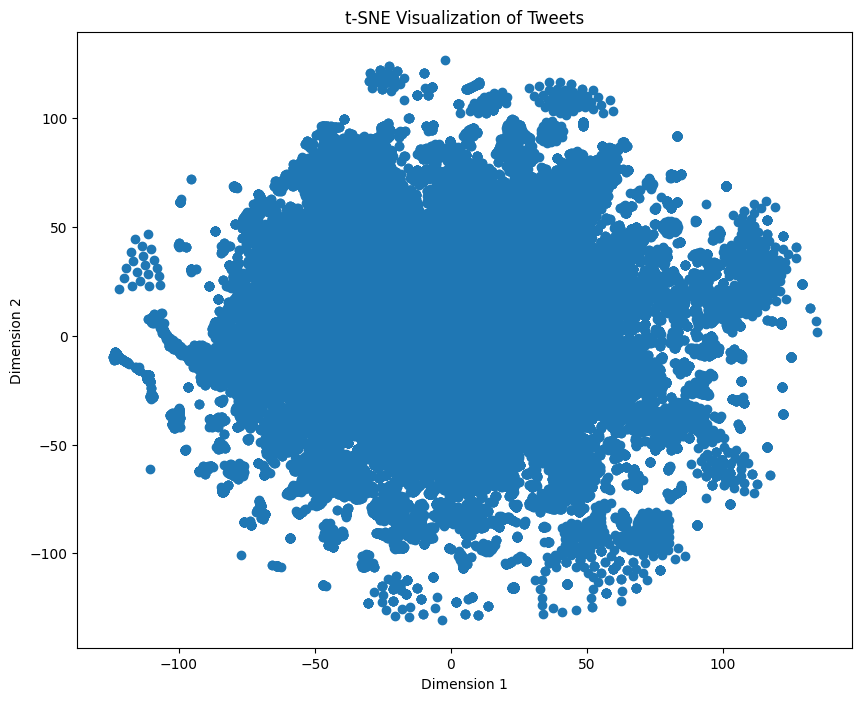

In [65]:
visualize_tweets(processed_tweets_dict, model)